In [62]:
import galsim
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Meta-parameter
n_star = 100
wid_strip, n_strip = 12, 14
mu = 884
sigma = 1e-1

In [3]:
# Image Parameter
image_size = 401
pixel_scale = 2.5                                # arcsec/pixel

# PSF Parameters
beta_psf = 10                                    # moffat beta, in arcsec
fwhm = 2.28 * 2.5
gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pixel_scale                  # moffat core width, in pix

n0 = 3.3                                         # true power index
n_s = np.array([n0, 2.8, 1.5, 4])
frac = 0.1                                       # fraction of power law component
theta_0 = 5.                                     # radius at which power law is flattened, in arcsec
theta_s = np.array([theta_0, 60, 150, 900])      # transition radius in arcsec

In [51]:
# Single-power PSF
params_pow = {"gamma":gamma, "beta":beta_psf, "frac":frac, "n":n0, 'theta_0':theta_0}
psf = PSF_Model(params=params_pow, aureole_model='power')

In [4]:
# Multi-power PSF
params_mpow = {"gamma":gamma, "beta":beta_psf, "frac":frac, "n_s":n_s, 'theta_s':theta_s}
psf = PSF_Model(params=params_mpow, aureole_model='multi-power')

In [5]:
# Build grid of image for drawing
psf.make_grid(image_size)

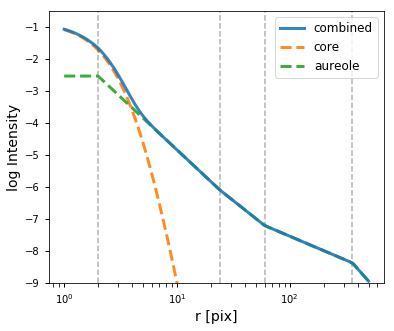

In [6]:
# Plot analytical 1D profile
psf.plot1D(psf_range=500)

# of medium bright (flux:7.2e+04~3.4e+05) stars: 17 
# of very bright (flux>1.2e+07) stars : 2
Not many bright stars, will draw in serial.


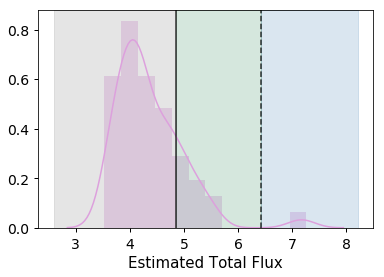

In [87]:
# Star Distribution (position, flux)
############################################

# Generate randomn star positions
np.random.seed(626)
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1

# Read SE measurement based on APASS
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor").to_pandas()
Flux_Auto_SE = SE_cat_full[SE_cat_full['FLAGS']<8]["FLUX_AUTO"]

# Star flux sampling from SE catalog
np.random.seed(888)
Flux = Flux_Auto_SE.sample(n=n_star).values

# Augment Flux
Flux = Flux * 10
Flux[Flux>1e6] = Flux[Flux>1e6] * 10

# Convert Flux to Astropy Moffat Amplitude
Amps = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Flux])

# Thresholds depending on the actual PSF, noise level, 
# magnitude distribution of stars, which affect speed and accuracy.
# Faint stars are rendered with fixed PSF in advance.
# Very bright stars are rendered in real space.
F_bright = 7e4
F_verybright = 2.7e6

stars = Stars(star_pos, Flux, Flux_threshold=[F_bright, F_verybright])
stars.plot_flux_dist()

In [8]:
psf_c = psf.generate_core()
psf_e, psf_size = psf.generate_aureole(contrast=1e6, psf_range=image_size)
star_psf = (1-frac) * psf_c + frac * psf_e

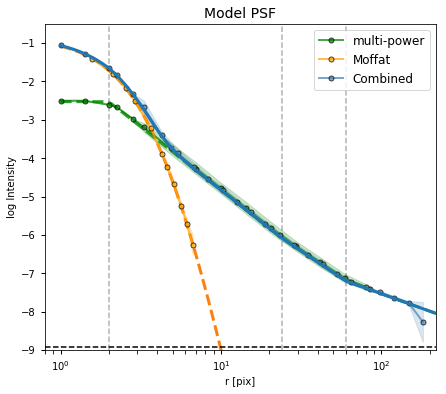

In [9]:
# Galsim 2D model averaged in 1D
contrast = Amps.max() / sigma * 3
psf.plot_model_galsim(psf_c, psf_e, image_size, contrast=contrast)

Generate noise background w/ stddev = 0.1
Generate base image of faint stars (flux < 7e+04).
Generate the truth image.
Rendering bright stars in serial...
Total Time: 0.466s


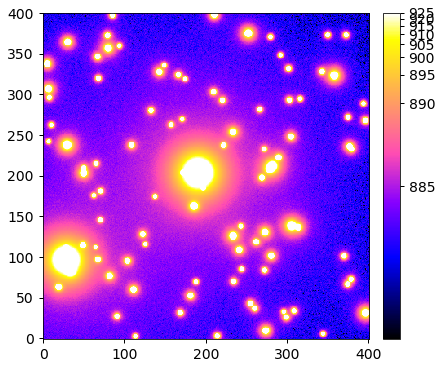

In [79]:
# Make noise image
noise_image = make_noise_image(image_size, sigma)

# Make sky background and dim stars
image_base = make_base_image(image_size, stars, psf_base=star_psf)

# Make truth image
image = make_truth_image(psf, stars)
image = image + image_base + mu + noise_image

# Display Truth
plt.figure(figsize=(7,6))
im = plt.imshow(image, vmin=mu, vmax=925, norm=norm1); colorbar(im)

Mask inner regions of stars in dual mode:  S/N > 3.0 / r < 48 (24) pix 
Use sky strips crossing very bright stars


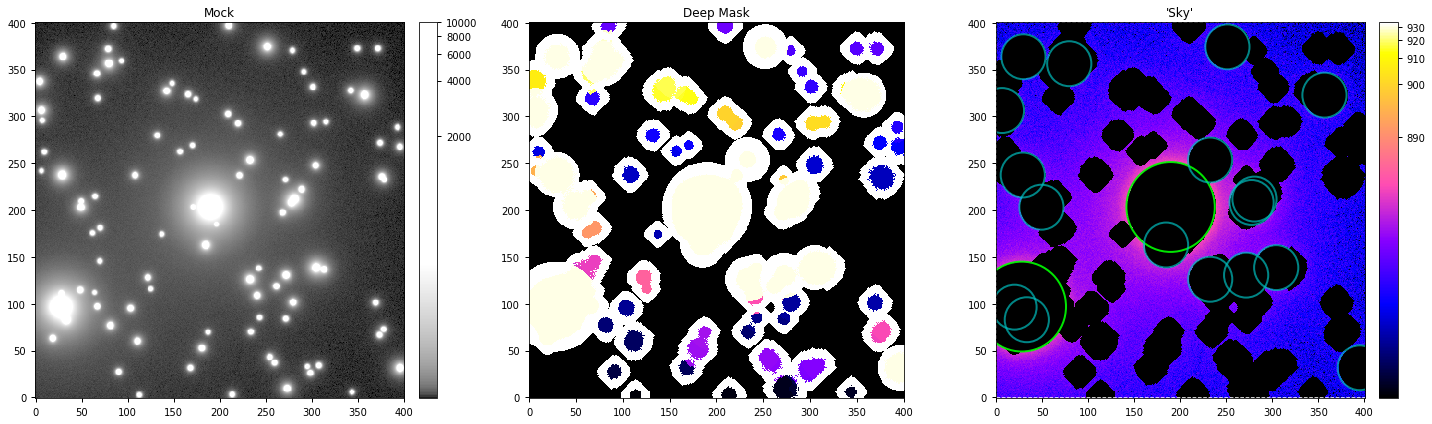

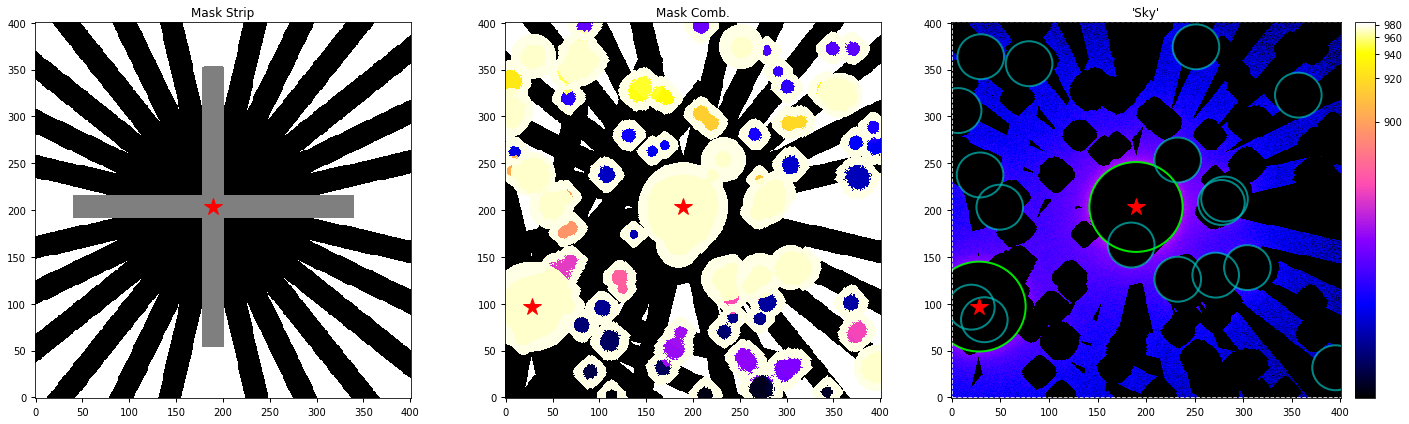

In [73]:
# Masking

# Core mask
r_core_A, r_core_B = [48, 24]
r_core_s = [r_core_A, r_core_B]

mask_deep, seg_map, _ = make_mask_map_dual(image, stars, image_size,
                                           r_core=r_core_s, sn_thre=3,
                                           nlevels=128, contrast=0.001,
                                           b_size=25, npix=4, n_dilation=10)
# Display core mask
draw_mask_map(image, seg_map, mask_deep, stars,
              r_core=r_core_s, vmin=mu, vmax=mu+50)

# Cross & strip mask
mask_strip_s, mask_cross_s = make_mask_strip(image_size, stars,
                                             width=wid_strip, n_strip=n_strip,
                                             dist_strip=300)
mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
seg_comb = seg_map.copy()
seg_comb[mask_strip_all&(seg_map==0)] = seg_map.max()+1
mask_comb = (seg_comb!=0)

# Display cross & strip mask
draw_mask_map_strip(image, seg_comb, mask_comb, stars,
                    ma_example=[mask_strip_s[0], mask_cross_s[0]],
                    r_core=r_core_s, vmin=mu, vmax=mu+100)

Test of generating mock images...
Done! Total Time: 0.329s



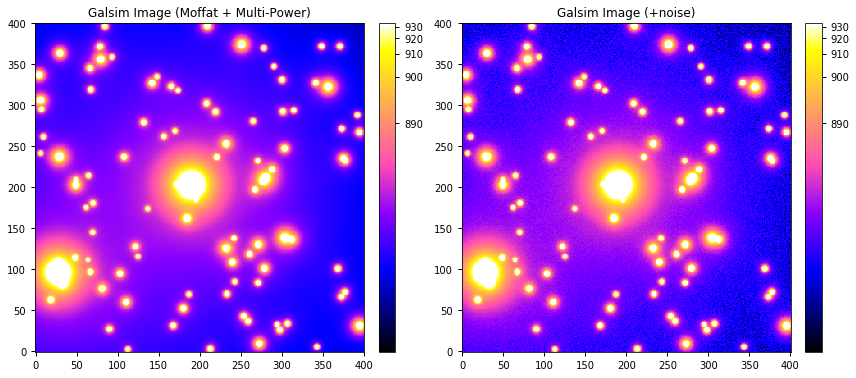

In [72]:
# Draw test
print("Test of generating mock images...")
start = time.time()
image_tri = generate_mock_image(psf, stars) + image_base
end = time.time()
print("Done! Total Time: %.3fs\n"%(end-start))

# Compare mock and truth
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
im = ax1.imshow(image_tri, vmin=mu, vmax=mu+50, norm=norm1); colorbar(im)
im = ax2.imshow(image_tri + noise_image, vmin=mu, vmax=mu+50, norm=norm1); colorbar(im)
ax1.set_title("Galsim Image (Moffat + Multi-Power)")
ax2.set_title("Galsim Image (+noise)")
plt.tight_layout()   

In [78]:
# Truths and estimates
############################################

labels = [r'$n0$', r'$n1$', r'$\theta_1$', r'$\mu$', r'$\sigma$']
truths = np.concatenate([[n_s[0], n_s[-2]], [np.log10(theta_s[-2])], [mu, sigma]])
ndim = len(labels) if len(labels) == len(truths) else -1
print("Truths: ", np.around(truths, 3))
print("Labels: ", labels)
    
mask_fit = mask_comb

X = np.array([psf.xx,psf.yy])
Y = image[~mask_fit].copy().ravel()

# Estimated mu and sigma used as prior
Y_clip = sigma_clip(Y, sigma=3, maxiters=10)
mu_patch, std_patch = np.mean(Y_clip), np.std(Y_clip)
print("Estimate of Background: (%.3f, %.3f)"%(mu_patch, std_patch))

Truths:  [3.300e+00 1.500e+00 2.176e+00 8.840e+02 1.000e-01]
Labels:  ['$n0$', '$n1$', '$\\theta_1$', '$\\mu$', '$\\sigma$']
Estimate of Background: (884.626, 0.317)


In [88]:
# Priors and Likelihood Models for Fitting
############################################

def prior_tf_2p(u):
    v = u.copy()
    v[0] = u[0] * 0.6 + 3             # n0 : 3-3.6
    v[1] = u[1] * (v[0]-1.2) + 1.2    # n1 : 1.2-n0
    v[2] = u[2] * 0.8 + 1.7           # log theta1 : 50-300  # in arcsec
    v[-2] = stats.truncnorm.ppf(u[-2], a=-2, b=0.1,
                                loc=mu_patch, scale=std_patch)         # mu
    v[-1] = stats.truncnorm.ppf(u[-1], a=-1, b=0.1,
                                loc=np.log10(std_patch), scale=0.5)    # log sigma 
    return v

def loglike_2p(v):
    n_s = v[:2]
    theta_s = [theta_0, 10**v[2]]
    mu, sigma = v[-2], 10**v[-1]
    
    psf.update({'n_s':n_s, 'theta_s':theta_s})
    
    image_tri = generate_mock_image(psf, stars, brightest_only=True, parallel=False)
    image_tri = image_tri + image_base + mu 
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike


Run Nested Fitting for the image... Dim of params: 5
Opening pool: # of CPU used: 3


iter: 3573 | batch: 2 | bound: 130 | nc: 2 | ncall: 23328 | eff(%): 15.316 | loglstar: 46556.866 < 46560.933 < 46558.166 | logz: 46531.869 +/-  0.735 | stop:  4.450                                  


Finish Fitting! Total time elapsed: 749s


/home/qliu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/qliu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


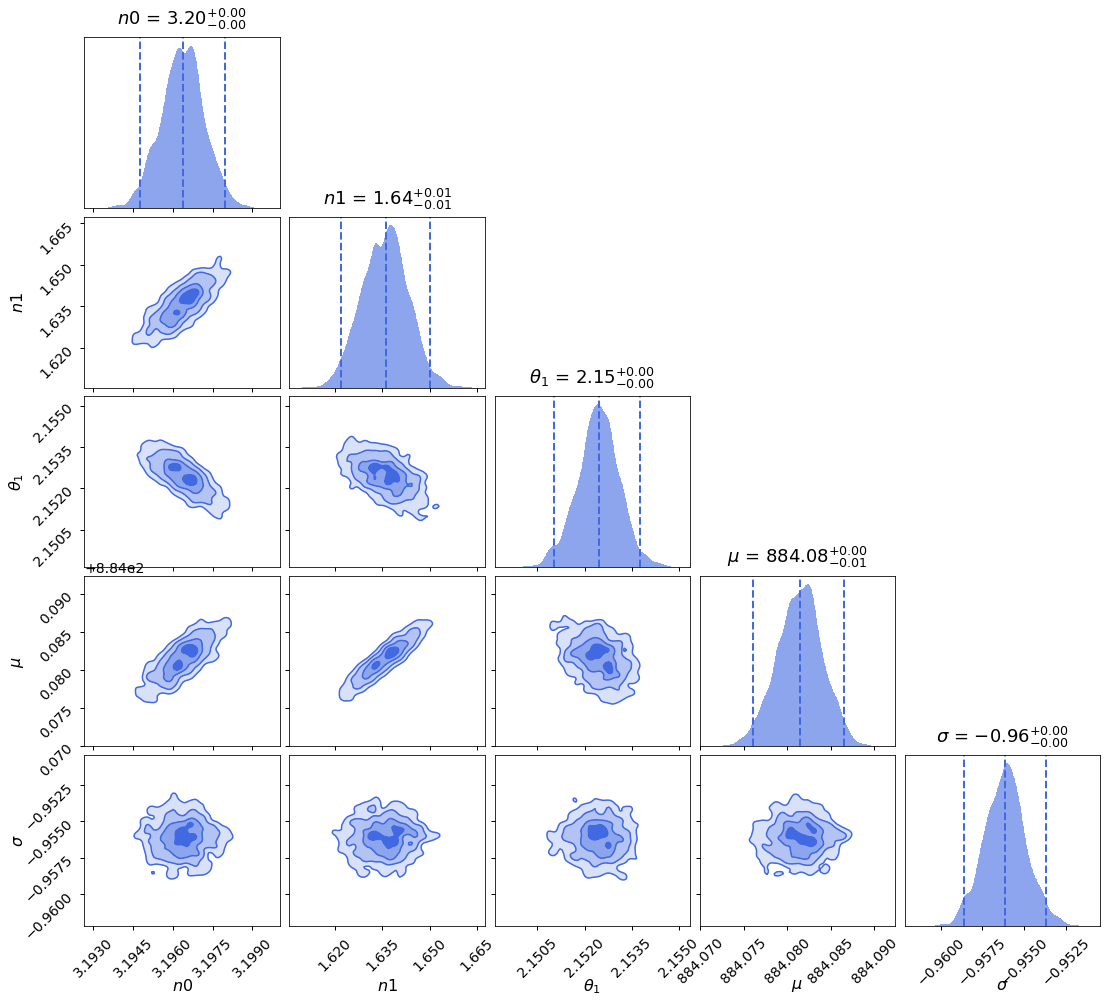

In [89]:
# Run & Plot
############################################

# Run Fitting
pdsampler = Run_Dynamic_Nested_Fitting(loglike_2p, prior_tf_2p, ndim, nlive_init=100)
pdres = pdsampler.results

# Plot Result
fig, axes = dyplot.cornerplot(pdres, truths=truths, labels=labels, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':18, 'y': 1.04},
                              label_kwargs={'fontsize':16}, show_titles=True, 
                              fig=plt.subplots(ndim, ndim, figsize=(16, 14)))

Fitting (mean):  [  3.19636647   1.63585978   2.15243885 884.08143256  -0.95613044]
Fitting (median):  [  3.19636597   1.63606015   2.15245103 884.08151809  -0.95613055]


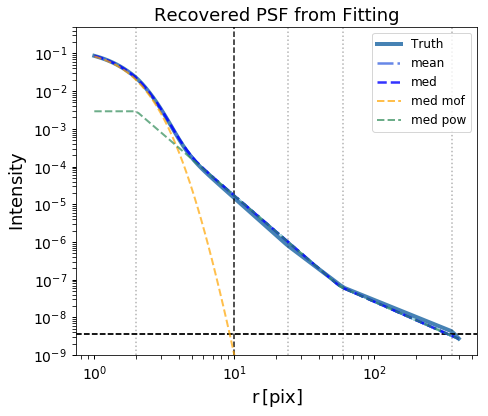

In [106]:
true_pars = {"gamma":gamma_pix, "alpha":beta_psf, "frac":frac}
for i in range(len(n_s)):
    true_pars["n%d"%i] = n_s[i]
for i in range(len(theta_s)):
    true_pars["theta%d"%i] = theta_s[i]
    
plot_fitting_vs_truth_PSF_mpow(pdres, n_bootstrap=500, image_size=image_size, save=False, true_pars = true_pars)
plt.axvline(10, ls="--", color="k",alpha=0.9)

In [105]:
def plot_fitting_vs_truth_PSF_mpow(res, true_pars, image_size=image_size, pix_scale=pixel_scale,
                                   n_bootstrap=200, save=False, dir_name="."):
    from dynesty import utils as dyfunc
    
    # read fitting results
    samples = res.samples                                 # samples
    weights = np.exp(res.logwt - res.logz[-1])            # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)     # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)  # resample weighted samples
    pmed = np.median(samples_eq,axis=0)                    # median sample
    
    print("Fitting (mean): ", pmean)
    print("Fitting (median): ", pmed)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootstrap)[0]
    
    # read params
    gamma, alpha, frac = true_pars["gamma"], true_pars["alpha"], true_pars["frac"]
    
    keys_n = [key for key in true_pars.keys() if "n" in key]
    keys_theta = [key for key in true_pars.keys() if "theta" in key]
    N_n, N_theta = len(keys_n), len(keys_theta)
    n_s = np.array([true_pars["n%d"%i] for i in range(N_n)])
    
    if N_theta > 0:
        theta_s = np.array([true_pars["theta%d"%i] for i in range(N_theta)])
        theta_s_pix = theta_s / pix_scale

    # 2D - 1D conversion for visual
    c_mof2Dto1D =  C_mof2Dto1D(gamma, beta_psf)
    c_mpow2Dto1D = C_mpow2Dto1D(n_s=n_s, theta_s=theta_s_pix)
    
    r = np.logspace(0., np.log10(image_size), 100)
    comp1 = moffat1d_normed(r, gamma=gamma, alpha=alpha) / c_mof2Dto1D
    comp2 = multi_power1d_normed(r, n_s=n_s, theta_s=theta_s_pix) / c_mpow2Dto1D
    
    # plot
    plt.figure(figsize=(7,6))
    
    plt.semilogy(r, (1-frac) * comp1 + frac * comp2,
                 label="Truth", color="steelblue", lw=4, zorder=2)
    
    N_n = (samples_eq_bs.shape[1] - 2) // 2 + 1
    N_theta = (samples_eq_bs.shape[1] - 2) // 2
    for sample_k in samples_eq_bs:
        
        n_s_k = sample_k[:N_n]
        
        if N_theta > 0:
            theta_1 = 10**sample_k[N_n:-2]
            theta_s_pix_k = np.append([theta_s[0]], theta_1) / pix_scale
        else:
            theta_s_pix_k = theta_s_pix 
            
        comp2_k = multi_power1d_normed(r, n_s=n_s_k, theta_s=theta_s_pix_k) / c_mpow2Dto1D

        plt.semilogy(r, (1-frac) * comp1 + frac * comp2_k,
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([pmed, pmean], ["royalblue", "b"],
                                  ["-.","--"], ["mean", "med"]):
            
            n_s_fit = fits[:N_n]
            if N_theta > 0:
                theta_s_pix_fit = np.append([theta_s[0]], 10**fits[N_n:-2]) / pix_scale
            else:
                theta_s_pix_fit = theta_s_pix 
            comp2 = multi_power1d_normed(r, n_s=n_s_fit, theta_s=theta_s_pix_fit) / c_mpow2Dto1D
            y_fit = (1-frac) * comp1 + frac * comp2
            
            plt.semilogy(r, y_fit, color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
            if l=="med":
                plt.semilogy(r, (1-frac) * comp1,
                             color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=4)
                plt.semilogy(r, frac * comp2,
                             color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=4)
            std_fit = 10**fits[-1]
            contrast = Amps.max()/(std_fit)
            plt.axhline(y_fit.max()/contrast,color="k",ls="--",alpha=0.9)
            
    for theta in theta_s_pix:
        plt.axvline(theta, ls=":", color="k",alpha=0.3)
    
    plt.legend(loc=1, fontsize=12)    
    plt.xlabel(r"$\rm r\,[pix]$",fontsize=18)
    plt.ylabel(r"$\rm Intensity$",fontsize=18)
    plt.title("Recovered PSF from Fitting",fontsize=18)
    plt.xscale("log")
    plt.ylim(1e-9, 0.5)    
    plt.tight_layout()
    
    if save:
        plt.savefig("%s/Fit_PSF.png"%dir_name,dpi=150)
        plt.close()